# 📊 00_eda_overview.ipynb
**Exploratory Data Analysis: Fraud Detection in Financial Transactions**

This notebook walks through the data behind our fraud detection problem using a synthetic dataset based on real financial transactions. We'll explore types of transactions, the distribution of fraud, and how fraud differs from genuine behavior.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='whitegrid')

In [3]:
# Load data
df = pd.read_csv('../data/train_fraud.csv')
print(f"Training set size: {len(df)}")
df.head()

Training set size: 28000


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,183,CASH_OUT,111979.77,C469489396,25021.00,0.00,C378419511,396580.04,508559.81,0
1,185,CASH_OUT,95198.49,C1783382289,143991.00,48792.51,C2001708620,2939.24,98137.73,0
2,10,CASH_OUT,163239.95,C1680102368,502232.03,338992.09,C1286783796,170192.81,0.00,0
3,208,CASH_OUT,479700.06,C1469158979,266826.00,0.00,C943774302,13842.18,493542.23,0
4,402,CASH_OUT,317353.24,C130561079,0.00,0.00,C1173729719,2760546.43,3077899.67,0


## ⚖️ Class Balance

Class balance:
0    26280
1     1720
Name: isFraud, dtype: int64
Class balance (normalized):
0    0.938571
1    0.061429
Name: isFraud, dtype: float64


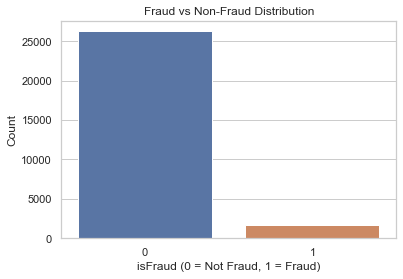

In [4]:
# Class distribution
class_counts = df['isFraud'].value_counts()
print("Class balance:")
print(class_counts)
class_counts = df['isFraud'].value_counts(normalize=True)
print("Class balance (normalized):")
print(class_counts)

sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('isFraud (0 = Not Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

### 💡Conclusion 1:
Only 6% of cases are fraud!

## 💸 Transaction Types and Amounts

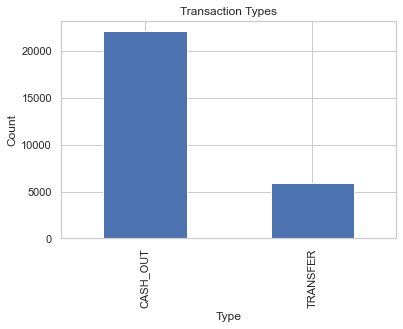

In [5]:
# Count of transaction types
df['type'].value_counts().plot(kind='bar')
plt.title('Transaction Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

### 💡Conclusion 2:
There are ~3-4 times the amount of Cash Out transactions than Transfer transactions.

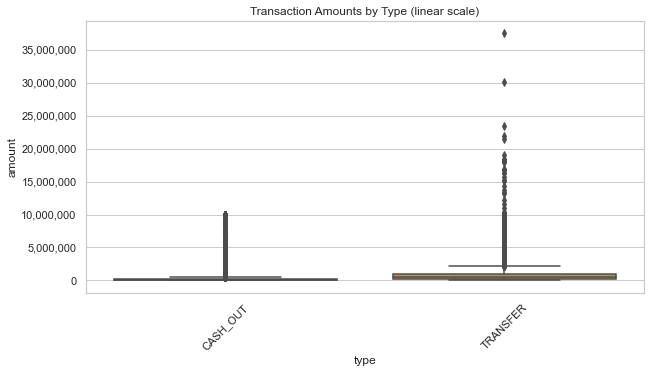

In [6]:
# Amount distributions by transaction type
from matplotlib.ticker import ScalarFormatter, FuncFormatter


fig = plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='type', y='amount')
plt.yscale('linear')
plt.title('Transaction Amounts by Type (linear scale)')
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.set_minor_formatter(FuncFormatter(lambda y, pos: f"{y:,.0f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:,.0f}"))
plt.show()

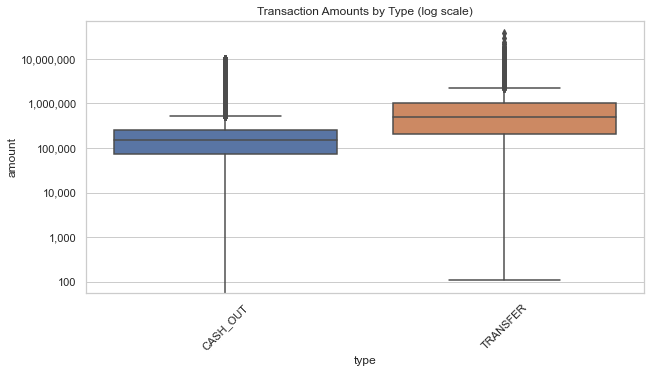

In [7]:
# Amount distributions by transaction type
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='type', y='amount')
plt.yscale('log')
plt.title('Transaction Amounts by Type (log scale)')
plt.xticks(rotation=45)
ax = plt.gca()
# ax.yaxis.set_minor_formatter(FuncFormatter(lambda y, pos: f"{y:,.0f}"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:,.0f}"))
plt.show()

## 🔍 Fraud by Transaction Type

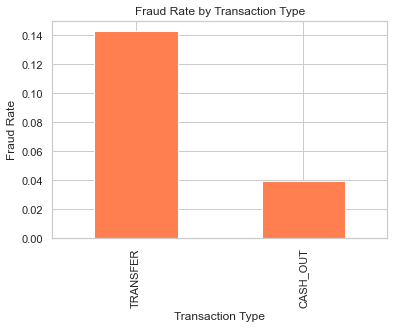

In [8]:
# Fraud share by transaction type
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', color='coral')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.xlabel('Transaction Type')
plt.show()

## 📉 Balance Behavior: Before and After

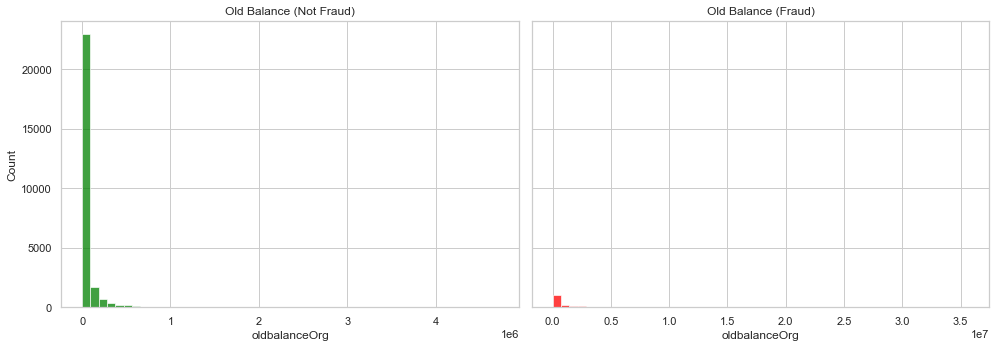

In [9]:
# Compare old and new balances for fraud and non-fraud
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.histplot(df[df['isFraud'] == 0]['oldbalanceOrg'], bins=50, ax=axes[0], color='green')
axes[0].set_title('Old Balance (Not Fraud)')
sns.histplot(df[df['isFraud'] == 1]['oldbalanceOrg'], bins=50, ax=axes[1], color='red')
axes[1].set_title('Old Balance (Fraud)')
plt.tight_layout()
plt.show()

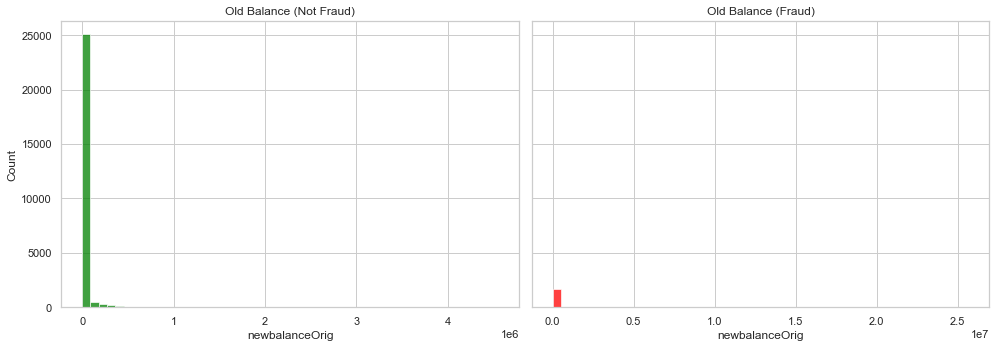

In [10]:
# Compare old and new balances for fraud and non-fraud
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.histplot(df[df['isFraud'] == 0]['newbalanceOrig'], bins=50, ax=axes[0], color='green')
axes[0].set_title('Old Balance (Not Fraud)')
sns.histplot(df[df['isFraud'] == 1]['newbalanceOrig'], bins=50, ax=axes[1], color='red')
axes[1].set_title('Old Balance (Fraud)')
plt.tight_layout()
plt.show()

## 🔍 Are expected merchant accounts accordingly labelled?¶


In [11]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? \n\n{}!'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? 

False!


In [12]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? \n\n{}!'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? 

False!


In [13]:
print('\nAre there merchants among any originator accounts? \n\n{}!'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? \n\n{}!'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? 

False!

Are there any transactions having merchants among destination accounts other than the PAYMENT type? 

False!


### 💡Conclusion 3:
Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

## 🔍 Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?¶

A possible modus operandi for committing fraud might involve first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT. However, the data shows below that there are no such common accounts among fraudulent transactions.

In [14]:
dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

In [15]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? \n\n{}!'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? 

False!


In [16]:
dfNotFraud = df.loc[df.isFraud == 0]
dfFraud = df.loc[df.isFraud == 1]

In [17]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud]
Index: []


In [18]:
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(dfFraud.loc[(dfFraud.oldbalanceDest == 0) & \
(dfFraud.newbalanceDest == 0) & (dfFraud.amount)]) / (1.0 * len(dfFraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(dfNotFraud.loc[(dfNotFraud.oldbalanceDest == 0) & \
(dfNotFraud.newbalanceDest == 0) & (dfNotFraud.amount)]) / (1.0 * len(dfNotFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4872093023255814

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.000532724505327245


In [19]:
from eda_helpers import plotStrip

/Users/shaypalachy/.pyenv/versions/py3/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


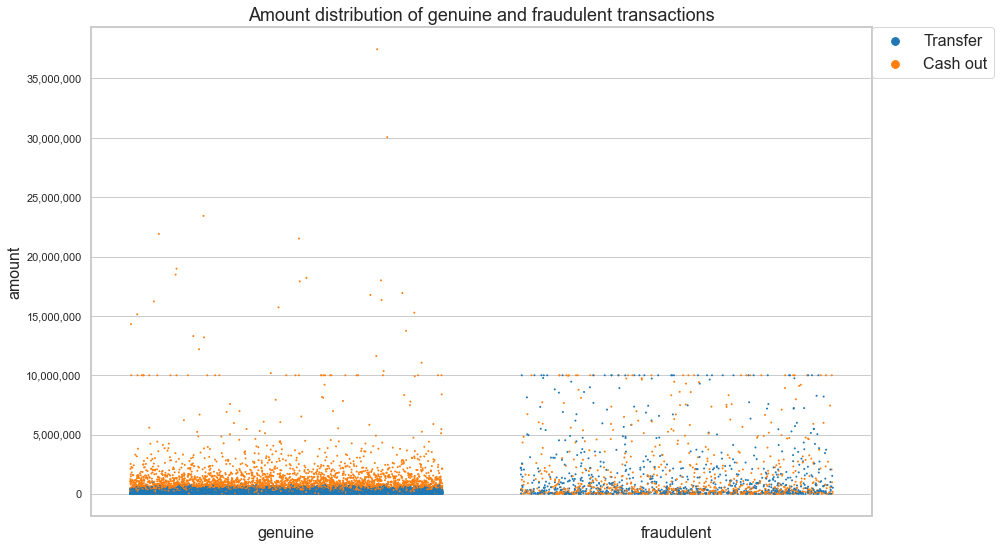

In [20]:
ax = plotStrip(df.isFraud, df.amount, df.type, figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Amount distribution of genuine and fraudulent transactions', size = 18);

## 🧠 Summary: What Did We Learn?
- Fraud occurs mostly in **TRANSFER** and **CASH_OUT** transactions.
- Fraud tends to involve **large transaction amounts**.
- Some patterns in **balances before/after** the transaction may signal fraud.
- Class imbalance is significant (~6% fraud), and this will affect modeling.

These insights help shape our modeling strategy — including feature engineering, choice of metrics, and evaluation approach.